In [20]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [21]:
heart = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
heart['cp'] = heart['cp'].astype('category')
heart['sex'] = heart['sex'].astype('category')
heart['restecg'] = heart['restecg'].astype('category')
heart.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [22]:
X = heart[["age","chol"]]
y = heart["cp"]

In [23]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
         make_column_selector(dtype_include=['category', 'object']))      
    ],
    remainder="passthrough"
)


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


## KNN

In [24]:
#KNN
#Tune to find optimal k

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]
)

k_values = [25,50,75, 100]  

# Parameter grid for GridSearchCV
k_param = {'knn__n_neighbors': k_values}

gscv = GridSearchCV(knn_pipeline, k_param, cv=5, scoring='accuracy')

#Fit to data
gscv_fitted = gscv.fit(X, y)

accuracy_scores = gscv_fitted.cv_results_['mean_test_score']

pd.DataFrame(data={"k values": k_values, "Acc scores": accuracy_scores})

,k values,Acc scores
0,25,0.454276
1,50,0.472458
2,75,0.476162
3,100,0.468822


In [25]:
#Using optimal k = 75

knn_pipeline50 = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors=75))]
)

#Fit on data
knn_model = knn_pipeline50.fit(X,y)

#Get AUC ROC score
scoresknn = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')

knn_acc = scoresknn.mean()

print(f"KNN Accuracy: {knn_acc}")

KNN Accuracy: 0.4761616161616161


## Decision Tree

In [26]:
#Dt Tuning

# Create a Decision Tree pipeline
dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier())
])

leaf_values = [1,50,75,100]

leaf_param = {
    'decision_tree__min_samples_leaf': leaf_values
}

gscv = GridSearchCV(dt_pipeline, leaf_param, cv=5, scoring='accuracy')

gscv.fit(X, y)

acc_scores = gscv.cv_results_['mean_test_score']

results_df = pd.DataFrame(data={"min_samples_leaf": leaf_values, "Acc scores": acc_scores})

results_df


,min_samples_leaf,Acc scores
0,1,0.362290
1,50,0.450438
2,75,0.461549
3,100,0.439529


In [27]:
#Using optimal minsamplesleaf = 75

dt_pipeline75 = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(min_samples_leaf=75))
])

#Fit on data
dt_model = dt_pipeline75.fit(X,y)

#Get AUC ROC score
scoresdt = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')

dt_acc = scoresdt.mean()

print(f"DT Accuracy: {dt_acc}")


DT Accuracy: 0.4615488215488216


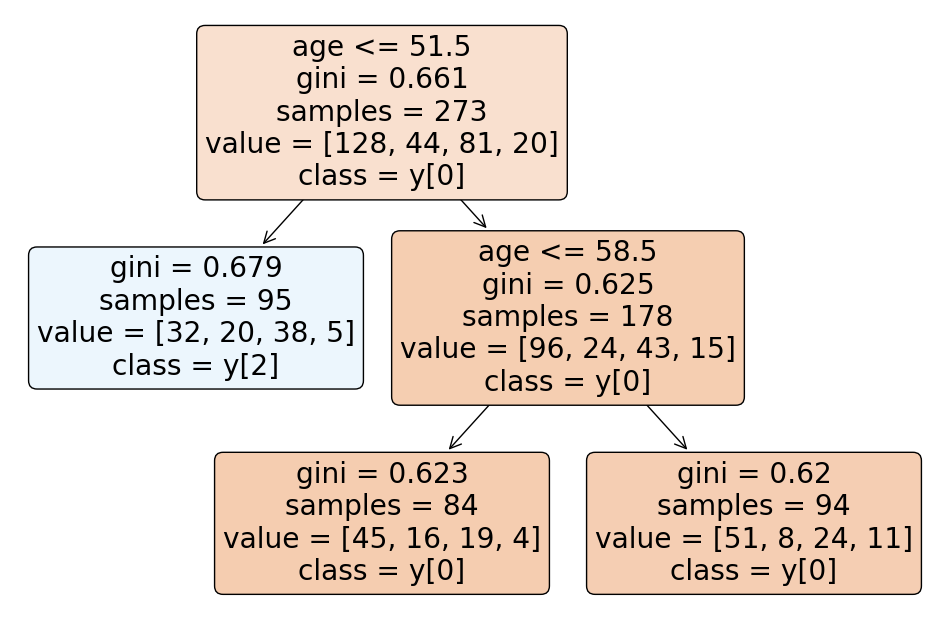

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming dt_model is your trained DecisionTreeClassifier from the pipeline
# Note: We extract the decision tree model from the pipeline
decision_tree_model = dt_pipeline75.named_steps['decision_tree']

# Plot the decision tree
plt.figure(figsize=(12,8))  # Set the size of the figure
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()


It looks like min_samples_leaf set to 75 gives the highest accuracy score for the Decision Tree. 54.5 years old looks to be a major factor in a patient having some form of chest pain.

## LDA

In [29]:
#LDA

lda_pipeline = Pipeline([
    ("preprocessing", ct),
    ("LDA", LinearDiscriminantAnalysis())
])

#Fit on data
lda_model = lda_pipeline.fit(X,y)

#Get AUC ROC score
scoreslda = cross_val_score(lda_model, X, y, cv=5, scoring='accuracy')

lda_acc = scoreslda.mean()

print(f"LDA Accuracy: {lda_acc}")

LDA Accuracy: 0.4468013468013468


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [30]:
#Create new columns
heart['cp_is_3'] = (heart['cp'] == 3).astype(int)
heart['cp_is_3'] = heart['cp_is_3'].astype('category')

heart['cp_is_2'] = (heart['cp'] == 2).astype(int)
heart['cp_is_2'] = heart['cp_is_2'].astype('category')

heart['cp_is_1'] = (heart['cp'] == 1).astype(int)
heart['cp_is_1'] = heart['cp_is_1'].astype('category')

heart['cp_is_0'] = (heart['cp'] == 0).astype(int)
heart['cp_is_0'] = heart['cp_is_0'].astype('category')

In [31]:
X = heart[["age", "chol"]]
y = heart["cp_is_3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

# Logistic regression pipeline
log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

# Fit on training data
log_model = log_pipeline.fit(X,y)

# Get F1 score
scoreslog = cross_val_score(log_model, X, y, cv=5, scoring='f1_macro')

log_f1 = scoreslog.mean()

print(f"cp = 3 Logistic Regression F1 Score: {log_f1}")


cp = 3 Logistic Regression F1 Score: 0.48098693759071115


In [32]:
X = heart[["age","chol"]]
y = heart["cp_is_2"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

# Logistic regression pipeline
log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

# Fit on training data
log_model = log_pipeline.fit(X, y)

# Get F1 score
scoreslog = cross_val_score(log_model, X, y, cv=5, scoring='f1_macro')

log_f1 = scoreslog.mean()

print(f"cp = 2 Logistic Regression F1 Score: {log_f1}")

cp = 2 Logistic Regression F1 Score: 0.41289526822038536


In [33]:
X = heart[["age","chol"]]
y = heart["cp_is_1"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

# Logistic regression pipeline
log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

# Fit on training data
log_model = log_pipeline.fit(X, y)

# Get F1 score
scoreslog = cross_val_score(log_model, X, y, cv=5, scoring='f1_macro')

log_f1 = scoreslog.mean()

print(f" cp = 1 Logistic Regression F1 Score: {log_f1}")

 cp = 1 Logistic Regression F1 Score: 0.45617641764176414


In [34]:
X = heart[["age","chol"]]
y = heart["cp_is_0"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

# Logistic regression pipeline
log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

# Fit on training data
log_model = log_pipeline.fit(X, y)

# Get F1 score
scoreslog = cross_val_score(log_model, X, y, cv=5, scoring='f1_macro')

log_f1 = scoreslog.mean()

print(f" cp = 0 Logistic Regression F1 Score: {log_f1}")

 cp = 0 Logistic Regression F1 Score: 0.5486327137775371


cp = 0 had the best F1 score and therefore was the best at distinguishing.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [35]:
# 0 and 1

zero_one = heart[heart['cp'].isin([0,1])]

X = zero_one[["age","chol"]]
y = zero_one["cp"]

log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

# Fit on training data
zero_one_log_model = log_pipeline.fit(X, y)


#Get AUC ROC score
scoreslog_zero_one = cross_val_score(zero_one_log_model, X, y, cv=5, scoring='roc_auc')

zero_one_roc = scoreslog_zero_one.mean()

print(f"Zero One ROC AUC: {zero_one_roc}")

Zero One ROC AUC: 0.6096410256410256


In [36]:
# 0 and 2

zero_2 = heart[heart['cp'].isin([0,2])]

X = zero_2[["age","chol"]]
y = zero_2["cp"]

log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

# Fit on training data
zero_2_log_model = log_pipeline.fit(X, y)


#Get AUC ROC score
scoreslog_zero_2 = cross_val_score(zero_2_log_model, X, y, cv=5, scoring='roc_auc')

zero_2_roc = scoreslog_zero_2.mean()

print(f"Zero Two ROC AUC: {zero_2_roc}")

Zero Two ROC AUC: 0.5822319004524886


In [37]:
# 0 and 3

zero_3 = heart[heart['cp'].isin([0,3])]

X = zero_3[["age","chol"]]
y = zero_3["cp"]

log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

# Fit on training data
zero_3_log_model = log_pipeline.fit(X, y)


#Get AUC ROC score
scoreslog_zero_3 = cross_val_score(zero_3_log_model, X, y, cv=5, scoring='roc_auc')

zero_3_roc = scoreslog_zero_3.mean()

print(f"Zero Three ROC AUC: {zero_3_roc}")

Zero Three ROC AUC: 0.37907692307692303


Zero and One had the highest ROC-AUC score out of all the one v one models.